### Bonus Questions

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from binarytree import tree, Node
import pandas as pd
from time import perf_counter  
from math import floor
from scipy.spatial.distance import euclidean
from sklearn.neighbors import NearestNeighbors

In [7]:
class KNN:
    def __init__(self):
        self.point_x_features = []
        self.point_y_features = []
        self.result_array = []

    def fit(self, dataframe):
        #       Omitting the first 4 columns of each row and keeping the features
        self.point_x_features = np.array(dataframe)[:, 4:]

    def kneighbors(self, testset, k):
        self.point_y_features = testset
        for point_y in self.point_y_features:
            self.result_array.append([self.get_neighbours_for_point(point_y[4:], k), point_y[:4]])
        return (self.result_array)

    def get_neighbours_for_point(self, point_y, k):
        self.neighbours = []
        #           Compute distances between x and all examples in the training set
        for point_x in enumerate(self.point_x_features):
            dst = euclidean(point_x[1], point_y)
            self.neighbours.append([point_x[0], dst])
        #           Sort points by distance and return indices of the first k neighbors
        self.neighbours = np.array(self.neighbours)
        k_idx = self.neighbours[:, 1].argsort()[:k]
        return (self.neighbours[k_idx])

### Task 8

Implemetation explanation:
- RKDT is the main class with the methods stated in the requirements.
- KD_tree is the class which is responsible for the KDtree data structure opearations.
- node is the class responsible for storing the points in each individual node in each KDtree.


In [42]:
class RKDT:
    d = 128  # Number of dimensions of dataset

    def __init__(self, training_data, n_0, l):
        self.training_data = training_data
        self.tree_list = []
        self.n_0 = n_0
        self.l = l

# Builds the trees for the RKDT
    def fit(self):
        for tree in range(self.l):
            new_tree = KD_tree(self.n_0, self.training_data, depth=0)
            self.tree_list.append(new_tree.create_tree(self.training_data, depth=0))

#  The main method which gets a test dataset and k - number of neighbors to return, loops over all the given test points
#  using the kneighbors_for_point method and return the NN index and distance.
    def kneighbors(self, test_data, k):
        df_features = test_data.iloc[:, 4:]
        neighbors = []
        for i in range(len(df_features)):
            neighbors.append((self.kneighbors_for_point(df_features.iloc[i], k)))
        return neighbors

#   uses the get_neighbor_from_leaf method to find possible neighbors and calculates distances to find NN for each point
    def kneighbors_for_point(self, point, k):
        neighbors_list = []
        temp_neighbors_array = []
        for tree in self.tree_list:
            neighbors_list.extend(self.get_neighbor_from_leaf(point, tree).values)
        neighbors_list = np.unique(neighbors_list)
        for n in neighbors_list:
            distance = euclidean(self.training_data.iloc[n][4:132],point)
            temp_neighbors_array.append([n, distance])
        if not temp_neighbors_array:
            return None
        elif len(temp_neighbors_array) < k:
            return None
        else:
            temp_neighbors_array.sort(key=lambda line: line[1])
            return temp_neighbors_array[:k]

# retrieves all the neighbors found in the leaf of the kdree for point
    def get_neighbor_from_leaf(self, point, root):
        if not root:
            return None
        elif not root.left and not root.right:
            return root.points_list
        elif root.left and not root.right:
            self.get_neighbor_from_leaf(point, root.left)
        elif not root.left and root.right:
            self.get_neighbor_from_leaf(point, root.right)
        else:
            feature_idx = int(root.chosen_feature[7:])
            if point.iloc[feature_idx-1] <= root.value:
                return self.get_neighbor_from_leaf(point, root.left)
            else:
                return self.get_neighbor_from_leaf(point, root.left)


In [43]:
class KD_tree:
   
    def __init__(self, n_0, training_data, depth):
        self.d = 128
        self.n_0 = n_0
        self.training_data = training_data
        training_data['idx'] = np.arange(len(training_data))

# Creates a new Kdtree
    def create_tree(self, training_data, depth):
        axis = np.random.randint(self.d) + 4 # we want to add 4 for ignoring the first 4 columns
        chosen_feature = training_data.columns[axis]  # stores the current used feature name
        if len(training_data) < self.n_0/2:  # stop condition
            return None
        sorted_points_list = training_data.sort_values(by=[chosen_feature], ascending=True)

        if len(sorted_points_list) % 2 == 0:

            median_idx = int(len(sorted_points_list) / 2)
        else:
            median_idx = floor(len(sorted_points_list) / 2)

        new_node = node(int(sorted_points_list.iloc[median_idx][chosen_feature]), chosen_feature)
        new_node.points_list = sorted_points_list['idx']


        new_node.left = self.create_tree(sorted_points_list.iloc[0:median_idx], depth + 1)
        new_node.right = self.create_tree(sorted_points_list.iloc[median_idx + 1:], depth + 1)

        return new_node

In [44]:
class node(Node):

    def __init__(self, value,chosen_feature):
        self.points_list = []
        self.value = value
        self.chosen_feature = chosen_feature
        self.right = None
        self.left = None

Task 3:
#### Executing RKDT on Hananya dataset for calulcation ratios and displaying 10 best results on images:

In [47]:
train_df_hananya = pd.read_csv('Hananya1.csv')
test_df_hananya = pd.read_csv('Hananya2.csv')
KD = RKDT(train_df_hananya, 50, 20)
KD.fit()
result_hananya = KD.kneighbors(test_df_hananya, 2)

Function for ratios calculation:

In [48]:
def calc_ratio(results):
    ratios_list = []
    for i in range(len(results)):
        first_neighbor_distance = result_hananya[i][0][1]
        second_neighbour_distance = result_hananya[i][1][1]
        ratios_list.append(first_neighbor_distance / second_neighbour_distance)
    return ratios_list

Calculating ratios and displaying results in a dataframe:

In [49]:
NN = []
for i in range(len(result_hananya)):
    NN.append(result_hananya[i][0][0])

SNN = []
for i in range(len(result_hananya)):
    SNN.append(result_hananya[i][1][0])
    
testpoint_idx = np.arange(len(test_df_hananya))

ratios = calc_ratio(result_hananya)

df_ratios = pd.DataFrame(testpoint_idx,columns =['test point index'])
df_ratios['NN'] = NN
df_ratios['SNN'] = SNN
df_ratios['Ratio'] = ratios

df_10_best_ratios = df_ratios[(df_ratios.Ratio < 0.8)]

df_10_best_ratios = df_10_best_ratios.nsmallest(10, 'Ratio')

df_10_best_ratios

,test point index,NN,SNN,Ratio
451,451,303,580,0.545487
379,379,354,504,0.579757
134,134,133,768,0.584066
206,206,192,421,0.594915
826,826,511,64,0.598174
435,435,296,133,0.624928
153,153,107,616,0.634592
584,584,522,268,0.642607
124,124,734,132,0.652221
638,638,580,139,0.653712


#### Displaying best points on the images:

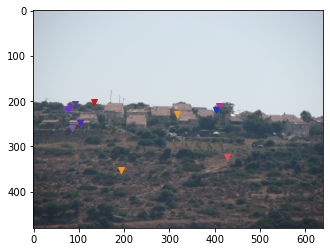

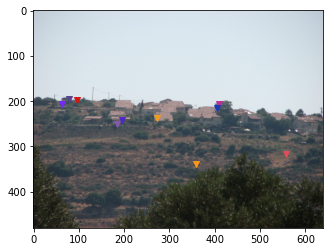

In [51]:
x = np.random.rand(10)
y = np.random.rand(10)
z = np.random.rand(10)

data1 = plt.imread('Hananya1.jpg')
for row  in enumerate(df_10_best_ratios.values):
    plt.plot(train_df_hananya.Y[df_10_best_ratios.values[row[0]][1]],
             train_df_hananya.X[df_10_best_ratios.values[row[0]][1]], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
plt.imshow(data1)
plt.show()


data2 = plt.imread('Hananya2.jpg')
for row  in enumerate(df_10_best_ratios.values):
    plt.plot(test_df_hananya.Y[df_10_best_ratios.values[row[0]][0]],
             test_df_hananya.X[df_10_best_ratios.values[row[0]][0]], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
plt.imshow(data2)
plt.show()



### Analysis of results of 10 best points according to ratio: 
#### All 10 points in Hanaya1 and Hanaya2 match as can be seen in the images

Task 4:

Searching for the values which will cause the optimal result (minimized mean error)

## Function for calculating the mean error and measuring run time:
We calculated the mean error using two different methods:
<b>
1) *Mean error based only on points for which, a nearest neighbor was found.<br> 
   Points without nearest neighbor were omitted from the mean error but counted and displayed for each iteration.*

2) *Normalized mean error for all points using weights based on frequency:*
</b><br>

<b>E1</b> = Error for points with nearest neighbor, it was calculated using the formula given in the instructions.<br>
<b>E2</b> = Error for each point without a neighbor is set to 1.<br>
<b>W1</b> = Amount of points with neighbor / total amount of points.<br> 
<b>W2</b> = Amount of points without neighbor / total amount of points.<br>
<b>Normalized_Mean_Error = E1*W1 + E2*W2</b>

These results can be seen in the table below and also the calculated time for each iteration.

In [54]:
def mean_error(dataset_x, dataset_y, knn_result, n_0, l):
    
    ann_iteration = RKDT(dataset_x, n_0,l)
    ann_iteration.fit()
    
    start = perf_counter()
    ann_results = ann_iteration.kneighbors(dataset_y, 1)
    end = perf_counter()
    elapsed_time = str(end - start)
    mean_error_result = 0
    count = 0     # counter for points without a neighbor
    for i in range(len(dataset_y)):
        if ann_results[i][0] is not None:
            # in case the algorithm found k neighbors
            ann_distance = ann_results[i][0][1]
            knn_distance = knn_result[i][0][0][1]
            epsilon_point_y = (ann_distance / knn_distance) - 1
            mean_error_result += epsilon_point_y
        else:
            count += 1
            
    good_points_error = mean_error_result/len(dataset_y)           # E1
    bad_points_error = 1                                           # E2
    good_points_weight = (len(dataset_y) - count)/len(dataset_y)   # W1
    bad_points_weight = count/len(dataset_y)                       # W2
    
    # calculating the mean error using method 1
    error = mean_error_result / (len(dataset_y) - count) 
    # normalize the results according to method 2
    normalized_error = good_points_error * good_points_weight + bad_points_error * bad_points_weight
    return normalized_error, elapsed_time, count, error

In [56]:
knn = KNN()
knn.fit(train_df_hananya.iloc[:,:132])
knn_result_hananya = knn.kneighbors(test_df_hananya.to_numpy(), 1)

error_list = []
time_list = []
n_0_list =[]
l_list = []
error_matrix = np.zeros((10,10))
time_matrix = np.zeros((10,10))

# The parameters we chose to test for finding the optimal result:
for l in range(15,20):
    for n_0 in range(35,60,5):
        normalized_error, time, count, error = mean_error(train_df_hananya, test_df_hananya, 
                                                          knn_result_hananya, n_0, l)        
        error_list.append(error)
        time_list.append(time)
        n_0_list.append(n_0)
        l_list.append(l)

In [57]:
df_mean_error = pd.DataFrame()
df_mean_error.insert(0, "N_0", n_0_list)
df_mean_error.insert(1, "L", l_list)
df_mean_error.insert(2, "Standard Error", error_list)
df_mean_error.insert(3, "Runtime", time_list)
# df_mean_error.insert(5, "Points without NN", count_list)

df_mean_error

,N_0,L,Standard Error,Runtime
0,35,15,0.118221,98.69849219999742
1,40,15,0.119201,101.11237200000323
2,45,15,0.147628,85.23246540001128
3,50,15,0.073679,139.31810729998688
4,55,15,0.071918,139.81143699999666
5,35,16,0.141268,93.13718190000509
6,40,16,0.123846,96.66624439999578
7,45,16,0.112619,97.59205809999548
8,50,16,0.063214,157.26485150000372
9,55,16,0.060904,166.74320110000554


The best hyper parameter (K,L) found (minimal error): 

In [58]:
df_mean_error.nsmallest(1,'Standard Error')

,N_0,L,Standard Error,Runtime
18,50,18,0.049475,264.76472549999016


Task 9:

Adding the ANN implementation with the addtion of the new methods adjusted for radius.

In [8]:
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_size = hash_size                     #k
        self.inp_dimensions = inp_dimensions           #D
        self.hash_table = dict()
        self.projections = np.random.randn(self.hash_size, inp_dimensions)       #randomize matrix K*D

    def generate_hash(self, list_features):
#       generate hash key using a dot product of point y features and projection matrix.
        bools = (np.dot(list_features, self.projections.T) > 0).astype('int')
        return ''.join(bools.astype('str'))

    def __setTable__(self, list_features, value):
#       Inserting values to specific cell according to the calulcated hash key
        hash_value = self.generate_hash(list_features)
        self.hash_table[hash_value] = self.hash_table.get(hash_value, list()) + [value]

    def __getTable__(self, list_features):
#       calculate a hash key for point_y and returns neighbors in the same cell,
#       returns empty list if no neighbors are found
        hash_value = self.generate_hash(list_features)
        return self.hash_table.get(hash_value, [])

In [9]:
class LSH:
    def __init__(self, num_tables, hash_size, inp_dimensions):
        self.num_tables = num_tables             # L - hash tables
        self.hash_size = hash_size               # K - hash size
        self.inp_dimensions = inp_dimensions     # D - dimensions size
        self.hash_tables = list()
        for i in range(self.num_tables):
#           Creates L hash tables  
            self.hash_tables.append(HashTable(self.hash_size, self.inp_dimensions))

    def __setitem__(self, index_x, list_features):
        for table in self.hash_tables:
#           call to set function of HashTable
            table.__setTable__(list_features, index_x)     

    def union_points(self, point_y):
#       Iterate all hash tables, returns a list of all possible neighbors found in each table
        union_points= list()
        for table in self.hash_tables:
            union_points.extend(table.__getTable__(point_y))
        uni_list = np.unique(np.asarray(union_points))
        return uni_list

In [10]:
class ANN:

    def __init__(self, l, k, d):
        self.point_x_features = []
        self.features_vectors_y = []
        self.point_x_names = []
        self.lsh = LSH(l, k, d)
        self.result_array = []
        self.result_dist_array = []

    def fit(self, dataframe):
        self.point_x_features = np.array(dataframe)[:, 4:]
        self.point_x_names = np.array(dataframe)[:, :4]
        # Mapping each point in training dataset to hash value and inserts them to tables
        for x in enumerate(self.point_x_features):
            self.lsh.__setitem__(x[0], x[1])

    def kneighbors(self, testset, k):
        # Dividing testset to points labels and features
        #In case the testset includes multiple rows
        if len(testset.shape) > 1:
            self.features_vectors_y = testset[:, 4:]
            points_labels_y = testset[:, :4]
        else:  
        # In case only 1 row was included in testset
            self.features_vectors_y = testset[4:]
            points_labels_y = testset[:4]

        for vector_y in enumerate(self.features_vectors_y):
            neighbors_for_point_y = self.getneighbors(vector_y[1], k)
            self.result_array.append([neighbors_for_point_y, vector_y[0]])
        return self.result_array

    def getneighbors(self, vector_y, k):
        # Calulates euclidean distance for each possible neighbors found by 'union_points' method 
        # returns distance and index of each neighbor         
        temp_neighbors_array = []
        neighbors = self.lsh.union_points(vector_y)
        for n in neighbors:
            distance = euclidean(vector_y, self.point_x_features[n])
            temp_neighbors_array.append([n, distance])
        if (not temp_neighbors_array) or (len(temp_neighbors_array) < k):
            # In case less than k neighbors are found - returns None
            return None
        else:
            neighbors_array_numpy = np.array(temp_neighbors_array, dtype=object,ndmin=2)
            # Sorting the list of neigbors by distance and returning the k nearest neigbors 
            k_idx = np.argsort(neighbors_array_numpy[:, 1])[:k]
            return neighbors_array_numpy[k_idx]

    def radius_neighbors(self, testset, knn_results, r):
        radius_result = []
        self.features_vectors_y = testset[:, 4:]      
        for vector_y in enumerate(self.features_vectors_y):
            neighbors2 = []
            temp_neighbors = self.lsh.union_points(vector_y[1])
            for n in temp_neighbors:
                real_distance = knn_results[vector_y[0]][0][0][1]        
                distance = euclidean(vector_y[1], self.point_x_features[n])
                if distance <= real_distance*r:
                    neighbors2.append([n, distance])
                
            if (not neighbors2):
                # In case less than k neighbors are found - returns None
                radius_result.append(0)
        
            else:
                neighbors2 = np.array(neighbors2, dtype=object,ndmin=2)
                # Sorting the list of neigbors by distance and returning the k nearest neigbors 
                idx = np.argsort(neighbors2[:, 1])
                radius_result.append(neighbors2[idx])
                
        return radius_result

In [15]:
l = 2      # number of hash tables
k = 4      # number of cuts and values for hash key calculation
d = 128    # number of dimentions
k_neighbors = 2 # number of wanted nearset neighbors


df_train_Hananya = pd.read_csv('Hananya1.csv')
df_test_Hananya = pd.read_csv('Hananya2.csv')
df_test_numpy_Hananya = df_test_Hananya.to_numpy()


ann_instance = ANN(l, k, d)
ann_instance.fit(df_train_Hananya)
result_radius = ann_instance.radius_neighbors(df_test_numpy_Hananya, knn_result_hananya, 1.5)

In [16]:
train_data = np.array(df_train_Hananya)[:, 4:]
test_data = np.array(df_test_Hananya)[:, 4:]
ann_sklearn = NearestNeighbors().fit(train_data)
distances = []
for i in range(len(test_data)):
    sklearn_distances, sklearn_indexes = ann_sklearn.radius_neighbors(test_data[i].reshape(1, -1), radius=knn_result_hananya[i][0][0][1]*1.5)
    distances.append(len(sklearn_indexes[0]))

In [18]:
result_count = []
for i in range(len(result_radius)):    
    result_count.append(len(result_radius[i]))


In [38]:
df_compare_results = pd.DataFrame()
df_compare_results.insert(0, "neighbors count - SKlearn",distances)
df_compare_results.insert(0, "neighbors count - Our ANN",result_count)
conditions = [df_compare_results['neighbors count - SKlearn'] == df_compare_results['neighbors count - Our ANN'],
              df_compare_results['neighbors count - SKlearn'] != df_compare_results['neighbors count - Our ANN']]
choices = ['True', 'False']
df_compare_results['Equal'] = np.select(conditions, choices)
display(df_compare_results)
print("Summary of results:")
print(df_compare_results['Equal'].value_counts())

,neighbors count - Our ANN,neighbors count - SKlearn,Equal
0,8,8,True
1,178,198,False
2,24,28,False
3,10,10,True
4,8,8,True
...,...,...,...
908,15,15,True
909,11,12,False
910,12,12,True
911,9,9,True


Summary of results:
False    838
True      75
Name: Equal, dtype: int64


## Analysis of Results:
As can be seen in the table, for most of the points of the test datasets, the SKlearn algorithm found more neighbors than our algorithm. We considered all these cases as errors of our algorithm so our algorithm return the correct answer (identical to SKlearn) in only 75 out of the 913 points (8%) and had 878 errors (96%) (found less neighbors than SKlearn).

This is expected since we saw that SKlearn algorithm had accuracy of 1 consistently on task 7. This can be explained also by the fact that the RKDT method is not entirely suitable for high number of dimensions and the use of some optimization techniques and methods from other liberaries in the SKlearn code which weren't used in our implementation.